In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, grad, vmap, jit, config
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu, elu, softplus
from jax.lax import while_loop, scan, cond

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from pathlib import Path

from jax.flatten_util import ravel_pytree

%matplotlib inline

In [2]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

In [3]:
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s,  mu_y = 0.0, sigma_y = 1.0,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u
        self.y = y
        self.s = s

        self.mu_y = mu_y
        self.sigma_y = sigma_y
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
      
        u = self.u[idx,:]
        y = self.y[idx,:]
        s = self.s[idx,:]

        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

In [4]:
# Define the model
class PI_DeepONet:
    def __init__(self, branch_layers, trunk_layers):    
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=elu)
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=elu)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=1000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []

    # Define DeepONet architecture
    def operator_net(self, params, u, y1, y2):
        y = np.stack([y1, y2])
        branch_params, trunk_params = params
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return outputs
      
    # Define PDE residual
    def residual_net(self, params, u, y1, y2):
        s_y1 = grad(self.operator_net, argnums = 2)(params, u, y1, y2)
        s_y2 = grad(self.operator_net, argnums = 3)(params, u, y1, y2)

        res = s_y1**2 + s_y2**2
        return res

    # Define boundary loss
    def loss_bcs(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        # Compute loss
        loss = np.mean((pred)**2)
        return loss

    # Define residual loss
    def loss_res(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.residual_net, (None, 0, 0, 0))(params, u, y[:,0], y[:, 1])
        # Compute loss
        loss = np.mean((pred - 1.0)**2)
        return loss    
    
    # Define total loss
    def loss(self, params, bcs_batch, res_batch):
        loss_bcs = self.loss_bcs(params, bcs_batch)
        loss_res = self.loss_res(params, res_batch)
        loss = 100 * loss_bcs + loss_res
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, bcs_batch, res_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, bcs_batch, res_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, bcs_dataset, res_dataset, nIter = 10000):
        bcs_data = iter(bcs_dataset)
        res_data = iter(res_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Fetch data
            bcs_batch= next(bcs_data)
            res_batch = next(res_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, bcs_batch, res_batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_value = self.loss(params, bcs_batch, res_batch)
                loss_bcs_value = self.loss_bcs(params, bcs_batch)
                loss_res_value = self.loss_res(params, res_batch)

                # Store losses
                self.loss_log.append(loss_value)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)

                # Print losses
                pbar.set_postfix({'Loss': loss_value, 
                                  'loss_bcs' : loss_bcs_value, 
                                  'loss_res': loss_res_value})
       
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return s_pred

In [5]:
# Load data
datafile = 'Data/airfoil.npy'
data = np.load(datafile, allow_pickle=True)
data = np.array(data)

In [6]:
data.shape

(1552, 253, 2)

In [7]:
D = data.reshape(-1, 2)
mu = D.mean(0)
sigma = D.std(0)

N_train = 1000
P_train = data.shape[1]
Q_train = 500

dom_coords = np.array([[-3, -3],
                       [3,  3]])

u_train_list = []
y_train_list = []
s_train_list = []

u_r_train_list = []
y_r_train_list = []
s_r_train_list = []

# Random key
key = random.PRNGKey(0)
subkeys = random.split(key, N_train)

# Create the training data 
for k in range(N_train):
  # Create training data for bcs loss
  u = (data[k] - mu) / sigma  # normalize data
  u_train = np.tile(u.flatten(), (P_train, 1))  # shape = (P_train, 2 * P_train)

  u_train_list.append(u_train)
  y_train_list.append(u)
  s_train_list.append(np.zeros((P_train, 1)))

  # create training data for physical loss
  u_r = np.tile(u.flatten(), (Q_train, 1))  # shape = (Q_train, 2 * P_train)
  y_r = dom_coords.min(0) + (dom_coords.max(0) - dom_coords.min(0)) * random.uniform(subkeys[k], shape=(Q_train, 2))

  u_r_train_list.append(u_r)
  y_r_train_list.append(y_r)
  s_r_train_list.append(np.ones((Q_train, 1)))

u_train = np.vstack(u_train_list)
y_train = np.vstack(y_train_list)
s_train = np.vstack(s_train_list)

u_r_train = np.vstack(u_r_train_list)
y_r_train = np.vstack(y_r_train_list)
s_r_train = np.vstack(s_r_train_list)

In [8]:
print(u_train.shape)
print(u_train)

(253000, 506)
[[ 1.7613982  -0.39896014  1.7120988  ... -0.4251667   1.7614592
  -0.46389347]
 [ 1.7613982  -0.39896014  1.7120988  ... -0.4251667   1.7614592
  -0.46389347]
 [ 1.7613982  -0.39896014  1.7120988  ... -0.4251667   1.7614592
  -0.46389347]
 ...
 [ 1.7614484  -0.35170597  1.7135907  ... -0.46024406  1.7614546
  -0.50126684]
 [ 1.7614484  -0.35170597  1.7135907  ... -0.46024406  1.7614546
  -0.50126684]
 [ 1.7614484  -0.35170597  1.7135907  ... -0.46024406  1.7614546
  -0.50126684]]


In [9]:
print(y_train.shape)
print(y_train)

(253000, 2)
[[ 1.7613982  -0.39896014]
 [ 1.7120988  -0.3313969 ]
 [ 1.6768825  -0.28337646]
 ...
 [ 1.6870791  -0.43534538]
 [ 1.7182018  -0.46024406]
 [ 1.7614546  -0.50126684]]


In [10]:
print(s_train.shape)
print(s_train)

(253000, 1)
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [11]:
print(u_r_train.shape)
print(u_r_train)

(500000, 506)
[[ 1.7613982  -0.39896014  1.7120988  ... -0.4251667   1.7614592
  -0.46389347]
 [ 1.7613982  -0.39896014  1.7120988  ... -0.4251667   1.7614592
  -0.46389347]
 [ 1.7613982  -0.39896014  1.7120988  ... -0.4251667   1.7614592
  -0.46389347]
 ...
 [ 1.7614484  -0.35170597  1.7135907  ... -0.46024406  1.7614546
  -0.50126684]
 [ 1.7614484  -0.35170597  1.7135907  ... -0.46024406  1.7614546
  -0.50126684]
 [ 1.7614484  -0.35170597  1.7135907  ... -0.46024406  1.7614546
  -0.50126684]]


In [12]:
print(y_r_train.shape)
print(y_r_train)

(500000, 2)
[[ 0.34339428  0.9167218 ]
 [-0.51620364  1.0724869 ]
 [-0.7747843  -1.3667679 ]
 ...
 [ 1.6280327  -2.5447805 ]
 [ 0.8212602   2.902235  ]
 [-2.8810515   2.8021412 ]]


In [13]:
print(s_r_train.shape)
print(s_r_train)

(500000, 1)
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [14]:
# Initialize model
branch_layers = [2 * P_train, 100, 100, 100, 100, 100]
trunk_layers =  [2, 100, 100, 100, 100, 100]
model = PI_DeepONet(branch_layers, trunk_layers)

# Before Training

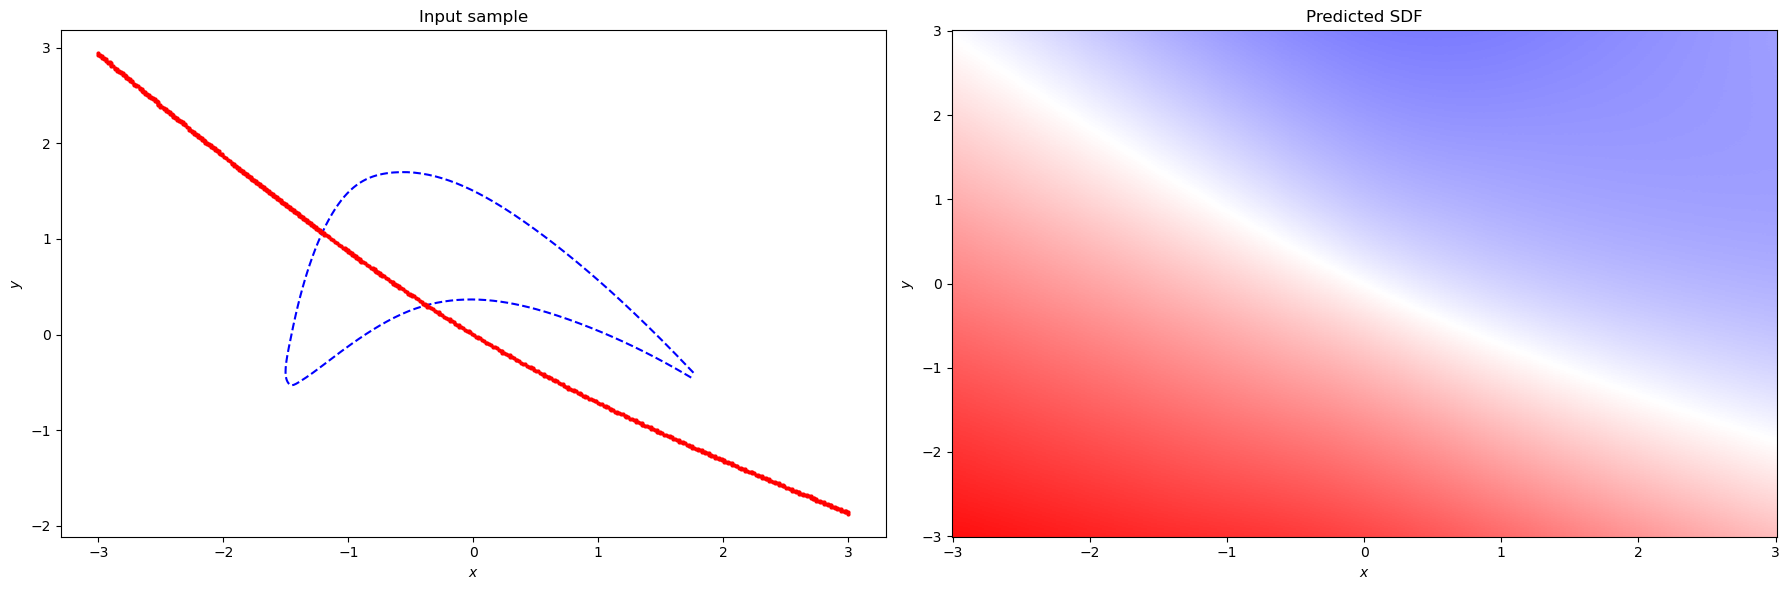

In [17]:
# Generate the test data
P_test = 400
idx = 0

u_test_list = []
y_test_list = []

u = (data[idx] - mu) / sigma
u_test = np.tile(u.flatten(), (P_test**2, 1))

y1 = np.linspace(dom_coords[0,0], dom_coords[1,0], P_test)
y2 = np.linspace(dom_coords[0,1], dom_coords[1,1], P_test)
y1, y2 = np.meshgrid(y1, y2)
y_test = np.hstack((y1.flatten()[:, None], y2.flatten()[:, None]))  # shape = (P^2, 2)

u_test_list.append(u_test)
y_test_list.append(y_test)

u_test = np.vstack(u_test_list)
y_test = np.vstack(y_test_list)

params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)[:,None]

# Visualizations
fig = plt.figure(figsize=(18,6))
index = np.arange(idx * P_test**2,(idx + 1) * P_test**2)

S_pred = griddata(y_test, s_pred[index, :].flatten(), (y1, y2), method='cubic')
mask = np.abs(s_pred[index, :]) < 5e-3

Y1 = y1.flatten()[:, None][mask]
Y2 = y2.flatten()[:, None][mask]

plt.subplot(1, 2, 1)
plt.plot(u[:,0], u[:,1], '--', label='Exact', color='blue')
plt.plot(Y1, Y2, '.', markersize=4, label='Predicted', color='red')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.tight_layout()
plt.title('Input sample')

plt.subplot(1, 2, 2)
plt.pcolor(y1, y2, S_pred, cmap='bwr')
# plt.colorbar()
plt.title('Predicted SDF')
plt.clim(-2., 2.)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.tight_layout()
plt.show()

# Training

In [18]:
# Create data set
batch_size = 10000
operator_dataset = DataGenerator(u_train, y_train, s_train, batch_size)
physics_dataset = DataGenerator(u_r_train, y_r_train, s_r_train, batch_size)

In [19]:
# Train
# model.train(operator_dataset, physics_dataset, nIter=40000)

100%|██████████| 40000/40000 [01:48<00:00, 367.11it/s, Loss=0.051367603, loss_bcs=0.0002529755, loss_res=0.02607005]  


In [20]:
path = Path('TrainedModels/airfoil')
path.mkdir(parents=True, exist_ok=True)

In [21]:
# Save the trained model
# params = model.get_params(model.opt_state)
# flat_params, _  = ravel_pytree(params)
# np.save(path/'ei_params.npy', flat_params)
# np.save(path/'ei_loss.npy', model.loss_log)
# np.save(path/'ei_loss_bcs.npy', model.loss_bcs_log)
# np.save(path/'ei_loss_res.npy', model.loss_res_log)

In [22]:
# Restore the trained model
flat_params = np.load(path/'ei_params.npy')
loss_bcs_log = np.load(path/'ei_loss_bcs.npy')
loss_res_log = np.load(path/'ei_loss_res.npy')
params = model.unravel_params(flat_params)

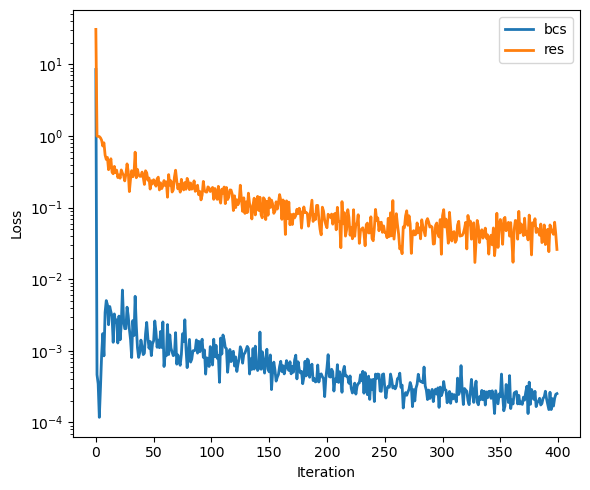

In [23]:
#Plot for loss function
plt.figure(figsize = (6,5))
plt.plot(loss_bcs_log, lw=2, label='bcs')
plt.plot(loss_res_log, lw=2, label='res')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

# After training

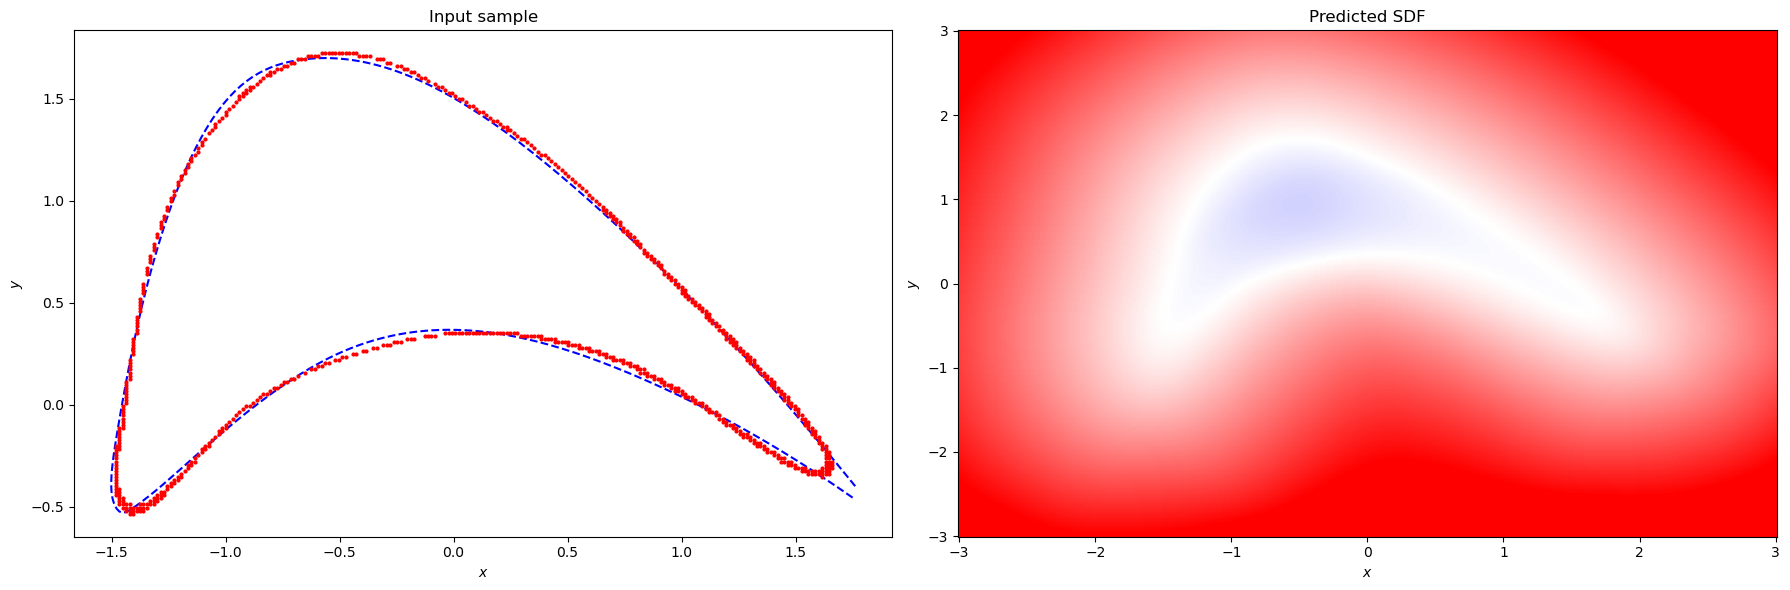

In [25]:
# Generate the test data
P_test = 400
idx = 0

u_test_list = []
y_test_list = []

u = (data[idx] - mu) / sigma
u_test = np.tile(u.flatten(), (P_test**2, 1))

y1 = np.linspace(dom_coords[0,0], dom_coords[1,0], P_test)
y2 = np.linspace(dom_coords[0,1], dom_coords[1,1], P_test)
y1, y2 = np.meshgrid(y1, y2)
y_test = np.hstack((y1.flatten()[:, None], y2.flatten()[:, None]))  # shape = (P^2, 2)

u_test_list.append(u_test)
y_test_list.append(y_test)

u_test = np.vstack(u_test_list)
y_test = np.vstack(y_test_list)

params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)[:,None]

# Visualizations
fig = plt.figure(figsize=(18,6))
index = np.arange(idx * P_test**2,(idx + 1) * P_test**2)

S_pred = griddata(y_test, s_pred[index, :].flatten(), (y1, y2), method='cubic')
mask = np.abs(s_pred[index, :]) < 5e-3

Y1 = y1.flatten()[:, None][mask]
Y2 = y2.flatten()[:, None][mask]

plt.subplot(1, 2, 1)
plt.plot(u[:,0], u[:,1], '--', label='Exact', color='blue')
plt.plot(Y1, Y2, '.', markersize=4, label='Predicted', color='red')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.tight_layout()
plt.title('Input sample')

plt.subplot(1, 2, 2)
plt.pcolor(y1, y2, S_pred, cmap='bwr')
# plt.colorbar()
plt.title('Predicted SDF')
plt.clim(-2., 2.)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.tight_layout()
plt.show()